In [1]:
import pandas as pd
import numpy as np
import pickle
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from plotnine import *
import pymannkendall as mk

import random
import os
import tqdm
from pathlib import Path

In [2]:
model_name = "scFoundation"

FILE_PATH = f"/home/ubuntu/{model_name}/extracted_cell_embeddings_PASCODE_c02x/"
SAVE_PATH = f"/home/ubuntu/{model_name}/results_pseudotime/" 

Path(SAVE_PATH).mkdir(parents=True, exist_ok=True)

In [3]:
with open("/home/ubuntu/scripts/Train_cv_to_send/Phenotype_classification_files/c02x_split_seed42_PAC.pkl","rb") as f:
    phen = pickle.load(f)

phen_label = ["r01x"]

donors = phen["train"]["SubID"].unique().tolist() + phen["test"]["SubID"].unique().tolist()

clinical_meta = pd.read_csv("/home/ubuntu/metadata_latest_oct5.csv",low_memory=False, index_col="SubID")
clinical_meta = clinical_meta.loc[donors].dropna(subset=phen_label)

phen_cell_meta = pd.concat([v for k,v in phen.items()])
phen_cell_meta_merge = pd.merge(phen_cell_meta,clinical_meta[phen_label], left_on="SubID", right_index=True)

final_donors = phen_cell_meta_merge["SubID"].unique().tolist()

Create Anndata from cell embeddings

In [ ]:
adata=None
for donor in tqdm.tqdm(final_donors):
    donor_df = pd.read_csv(f"{FILE_PATH}{donor}.csv", index_col=0)
    # donor_df = pd.read_csv(f"{FILE_PATH}{donor}.csv", header=None ) # only for Geneformer
    meta_obs_donor = phen_cell_meta_merge[phen_cell_meta_merge["SubID"]==donor]
    donor_df.index = meta_obs_donor.index

    if adata is None:
        adata = ad.AnnData(donor_df.values, obs=meta_obs_donor, var=donor_df.columns.to_frame())
    else:
        temp_adata = ad.AnnData(donor_df.values, obs=meta_obs_donor, var=donor_df.columns.to_frame())
        adata = ad.concat([adata, temp_adata])
        del temp_adata

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 229/404 [05:51<17:07,  5.87s/it]

In [7]:
# adata = ad.read_h5ad(f"{SAVE_PATH}c02x_pseudotime.h5ad")

Compute pseudotime

In [6]:
all_elements=np.flatnonzero(adata.obs['r01x']  == 0)
root=all_elements[random.randrange(len(all_elements))]

sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=20)
sc.tl.diffmap(adata)

adata.uns['iroot'] = root
sc.tl.dpt(adata)

In [8]:
sc.tl.umap(adata)

/home/ubuntu/miniconda3/envs/MLP/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


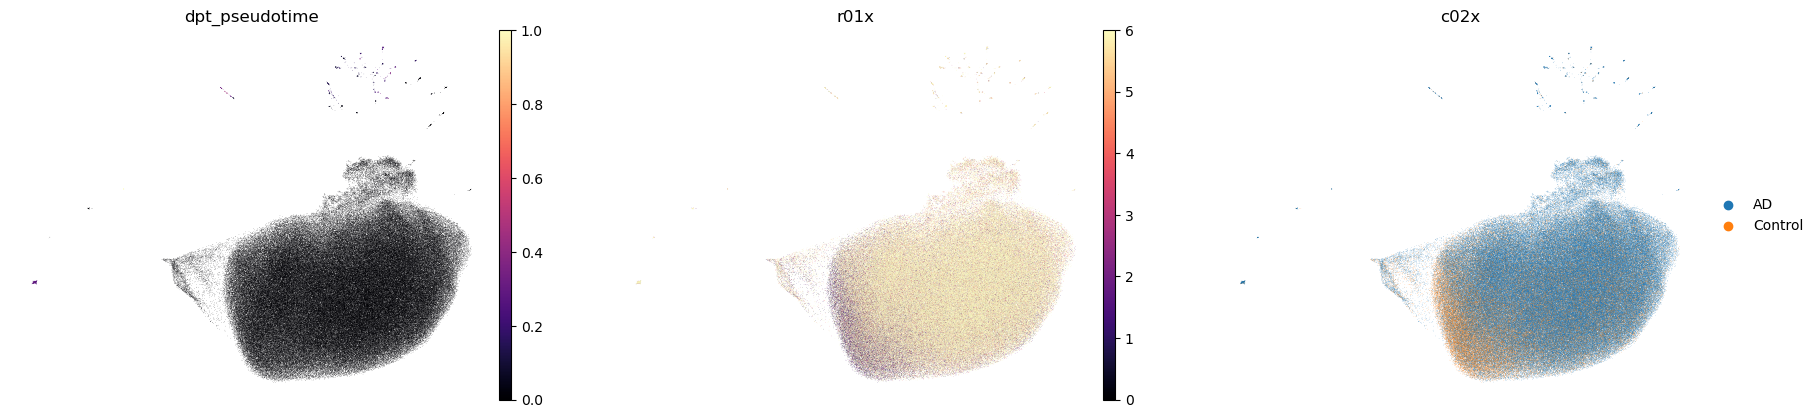

In [9]:
with plt.rc_context():  
    sc.pl.umap(adata, color=['dpt_pseudotime',"r01x","c02x"],show=False, frameon=False, color_map="magma")
    plt.savefig(f"{SAVE_PATH}{model_name}_{phen_label[0]}_cell_embedding_UMAP.png", dpi=300, bbox_inches="tight")
    plt.show()

In [ ]:
# Optional: for PAGA vizualization
# sc.tl.draw_graph(adata)
# with plt.rc_context():  
    # sc.pl.draw_graph(adata, color=['dpt_pseudotime',"r01x","c02x"],show=False, frameon=False, color_map="magma")
    # plt.savefig(f"{SAVE_PATH}{model_name}_{phen_label[0]}_cell_embedding_PAGA.png", dpi=300, bbox_inches="tight")

/home/ubuntu/miniconda3/envs/MLP/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 1.5 x 2.5 in image.
/home/ubuntu/miniconda3/envs/MLP/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/ubuntu/Geneformer/results_pseudotime/Geneformer_r01x_cell_embedding_boxplot.png
/home/ubuntu/miniconda3/envs/MLP/lib/python3.8/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 37 rows containing non-finite values.
/home/ubuntu/miniconda3/envs/MLP/lib/python3.8/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 37 rows containing non-finite values.


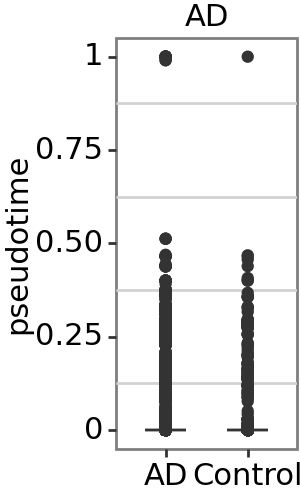

In [10]:
df = adata.obs
df = df[["c02x","dpt_pseudotime"]]

x="c02x"
xtitle=""
ytitle="pseudotime"
title="AD"
text=""

df=df.sort_values(by=[f"{x}"])
# result = mk.original_test(df["dpt_pseudotime"].values)
# p = result.p
# ad_samples = df[df["c02x"]=="AD"]["dpt_pseudotime"].values
# ctrl_samples = df[df["c02x"]=="Control"]["dpt_pseudotime"].values

# U1, p = mannwhitneyu(ad_samples, ctrl_samples, method="exact")
# print (p)
# if p > 0.0:
#     text="p<{:.2e}".format(p)
# else:
#     text="p={}".format(p)
p=""

p0=(
    ggplot(df, aes(f"{x}","dpt_pseudotime", fill=f"{x}"))
    + geom_boxplot( aes(weight=2), fatten=1, width=0.5,)# fill="lightblue")#colour="#1F3552", )#fill="#4271AE") +
    + theme_bw() 
    + theme(
        panel_grid_major=element_blank(),#element_line(colour="#d3d3d3"),
        panel_grid_minor=element_line(colour="#d3d3d3"),
        axis_text_x=element_text(colour="black", size=11,angle = 0,),
        axis_text_y=element_text(colour="black", size=11),
         text=element_text(size=11),
         legend_position="none",
         legend_title=element_blank(),
        plot_title=element_text(size=11,ha="center"),
        plot_subtitle = element_text(size = 9, ha="center"),
         figure_size=(1.5,2.5), )
    + xlab(f"{xtitle}")
    + ylab(f"{ytitle}")
     + scale_fill_manual(values={"Control": "#009e73", "AD": "#d55e00"})

  #+ geom_smooth(aes(group=1), method = "lm", color="black", linetype="dashed", size=0.5)
  + labs(title=f"{title}")#,subtitle =f"{text}",)  
  + annotate("text", x=1.5, y = 1, label=f"{text}", size=9)
      )

p0.save(f"{SAVE_PATH}{model_name}_{phen_label[0]}_cell_embedding_boxplot.png", dpi=300)
print (p0)

In [33]:
# quick counts of problematic rows
print("NaNs in each column")
print(df[["c02x", "dpt_pseudotime"]].isna().sum())

print("\n±inf in dpt_pseudotime")
print(np.isinf(df["dpt_pseudotime"]).sum())

# inspect a few bad rows
bad_mask = (
    df["c02x"].isna()
    | df["dpt_pseudotime"].isna()
    | np.isinf(df["dpt_pseudotime"])
)
df.loc[bad_mask].head()

NaNs in each column
c02x              0
dpt_pseudotime    0
dtype: int64

±inf in dpt_pseudotime
5628


,c02x,dpt_pseudotime
M10730-2-ATTCTTGAGTATGATG-1,AD,inf
M10730-1-TGTCAGAAGTGAACAT-0,AD,inf
M3038-2-GTGCTGGTCGGAACTT-1,AD,inf
M50883-2-GAGGCCTAGTGGTTGG-1,AD,inf
M44223-1-GTGCTTCGTGCCGAAA-0,AD,inf


In [23]:
df.dtypes

c02x              category
dpt_pseudotime     float32
dtype: object

In [ ]:
# adata.write_h5ad(f"{SAVE_PATH}c02x_pseudotime.h5ad")